### How do solar radiation and wind speed predict renewable energy generation?

This problem falls under regression since we are estimating a numerical outcome (energy generation) given input variables (solar radiation and wind speed conditions). For model selections, we are using Linear Regression as a baseline model and Random Forest to test various performance.

The overall data we will be using to interpret the question are:
 - Solar Radiation (W/m²): Measures the amount of solar energy received per unit area.
 - Wind Speed (m/s): Indicates the strength of wind which influences energy generation.
 - Time of Day and Season: Helps capture periodic trends in energy generation.

And our target variable is Renewable Energy Generation (kWh): The amount of energy produced from solar and wind sources.

With the given data and threshold of solar panel and wind turbines power generation, we can determine whether the value pass the threshold and extract them to time of day (day or night) and different seasons (spring, summer, winter). We drop the fall data our regression equation is: Total Energy Generation=β0 + β1(Spring)+ β2(Summer)+ β3(Winter). Fall is the baseline, and the coefficients tell us how energy generation in other seasons compares to Fall.

For our specific Linear Regression and Random test, our inputs X are 
- 'Time_of_Day_Nighttime'
- 'Season_Spring'
- 'Season_Summer'
- 'Season_Winter'

Our output y is 'Total_Energy_Generation'.
(See code below to see our process)

In [69]:
import pandas as pd
import numpy as np
import os
import zipfile
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
# define a mapping of ZIP filenames to their respective text files
zip_txt_mapping = {
    # "Hourlyairtemper.zip": "Air temperature.txt",
    "Hourlysolarradi.zip": "Solar radiation.txt",
    "Hourlywindspeed.zip": "Wind speed.txt"
}

def extract_zip(zip_filename):
    folder_name = zip_filename.replace(".zip", "")  # folder name without .zip
    
    if not os.path.exists(folder_name):  # avoid re-extracting if already done
        with zipfile.ZipFile(zip_filename, "r") as zip_ref:
            zip_ref.extractall(folder_name)
    return folder_name  # folder path

def read_txt_from_zip(zip_filename, delimiter="\t"):
    # extract the ZIP file
    folder_name = extract_zip(zip_filename)
    
    # get the corresponding text file
    txt_filename = zip_txt_mapping.get(zip_filename, None)
    txt_path = os.path.join(folder_name, txt_filename)  # construct file path

    if os.path.exists(txt_path):  # if the file exists
        df = pd.read_csv(txt_path, delimiter=delimiter)
        return df
    else:
        return None

zip_files = list(zip_txt_mapping.keys())  # extract ZIP filenames

# read data from each ZIP and store in a dictionary
dfs = {zip_file: read_txt_from_zip(zip_file) for zip_file in zip_files}

In [71]:
# display DataFrames as tables
for zip_file, df in dfs.items():
    display(df)

,Year,Month,Day,hhmm,Data,Flag
1948,1,1,100,0.0,131,NaN
1948,1,1,200,0.0,131,NaN
1948,1,1,300,0.0,131,NaN
1948,1,1,400,0.0,131,NaN
1948,1,1,500,0.0,131,NaN
...,...,...,...,...,...,...
2017,9,30,2000,0.0,0,NaN
2017,9,30,2100,0.0,0,NaN
2017,9,30,2200,0.0,0,NaN
2017,9,30,2300,0.0,0,NaN


,Year,Month,Day,hhmm,Data,Flag
1948,1,1,100,10.92,131,NaN
1948,1,1,200,10.92,131,NaN
1948,1,1,300,10.92,131,NaN
1948,1,1,400,10.92,131,NaN
1948,1,1,500,10.92,131,NaN
...,...,...,...,...,...,...
2017,9,30,2000,4.92,0,NaN
2017,9,30,2100,3.80,0,NaN
2017,9,30,2200,4.03,0,NaN
2017,9,30,2300,4.25,0,NaN


In [72]:
# define column names manually
column_names = ["Year", "Month", "Day", "hhmm", "Data", "Flag"]

# load datasets with the correct separator and column names
wind = pd.read_csv('./Hourlywindspeed/Wind speed.txt', sep=r'\s+', names=column_names, skiprows=1)
solar = pd.read_csv('./Hourlysolarradi/Solar radiation.txt', sep=r'\s+', names=column_names, skiprows=1)

# drop the 'Flag' column before renaming
wind.drop(columns=['Flag'], inplace=True)
solar.drop(columns=['Flag'], inplace=True)

# rename 'Data' column in each dataframe
wind.rename(columns={'Data': 'Wind_Speed'}, inplace=True)
solar.rename(columns={'Data': 'Solar_Radiation'}, inplace=True)

# merge the two datasets on Year, Month, Day, and hhmm
merge_columns = ['Year', 'Month', 'Day', 'hhmm']
merged_df = pd.merge(wind, solar, on=merge_columns, how='inner')

merged_df

,Year,Month,Day,hhmm,Wind_Speed,Solar_Radiation
0,1948,1,1,100,10.92,0.0
1,1948,1,1,200,10.92,0.0
2,1948,1,1,300,10.92,0.0
3,1948,1,1,400,10.92,0.0
4,1948,1,1,500,10.92,0.0
...,...,...,...,...,...,...
611419,2017,9,30,2000,4.92,0.0
611420,2017,9,30,2100,3.80,0.0
611421,2017,9,30,2200,4.03,0.0
611422,2017,9,30,2300,4.25,0.0


In [73]:
merged_df['hhmm'].unique()

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200,
       2300, 2400])

In [74]:
# Convert solar radiation from Langley to W/m²
merged_df['Solar_Radiation_Wm2'] = merged_df['Solar_Radiation'] * 11.63
merged_df.drop(columns=['Solar_Radiation'], inplace=True)

# Set thresholds
wind_threshold = 6.7
solar_threshold = 150

# Create binary columns based on thresholds
merged_df['Wind_Above_Threshold'] = (merged_df['Wind_Speed'] >= wind_threshold).astype(int)
merged_df['Solar_Above_Threshold'] = (merged_df['Solar_Radiation_Wm2'] >= solar_threshold).astype(int)
merged_df

,Year,Month,Day,hhmm,Wind_Speed,Solar_Radiation_Wm2,Wind_Above_Threshold,Solar_Above_Threshold
0,1948,1,1,100,10.92,0.0,1,0
1,1948,1,1,200,10.92,0.0,1,0
2,1948,1,1,300,10.92,0.0,1,0
3,1948,1,1,400,10.92,0.0,1,0
4,1948,1,1,500,10.92,0.0,1,0
...,...,...,...,...,...,...,...,...
611419,2017,9,30,2000,4.92,0.0,0,0
611420,2017,9,30,2100,3.80,0.0,0,0
611421,2017,9,30,2200,4.03,0.0,0,0
611422,2017,9,30,2300,4.25,0.0,0,0


According to Greenlancer, solar panels generates whenever sun is available, but the solar output depends on the solar intensity. We want to put a threshold on solar radiation to best generate energy with solar panels. In this case, "'Full sun' conditions occur when sunlight provides around 1,000 watts per square meter."


(source: https://www.greenlancer.com/post/peak-sun-hours#:~:text=How%20Many%20Solar%20Hours%20Per,than%20during%20peak%20sunlight%20hours.)


So if the solar radiation we have in the database above <= 1000 W/m² with minimum 100-200 W/m2, we will mark it as 1, and 0 otherwise. 

Moreover, because the data we have is in Langley, we need to convert them all to W/m². To convert Langleys to W/m2, multiply by 0.4845 given 1 Langley = 41,840 Joules/m2 (source USDA - Solar Radiation Unit Conversion).
- 1 Langley/day = 0.484583 Watt/m2 
- 1 Lang/hour = 11.6300 Watt/m2


From Reve, "the cut-in speed ranges from 3 to 4 meters per second (6.7 to 8.9 miles per hour)." (source: https://www.evwind.es/2023/11/02/what-is-the-minimum-speed-for-a-wind-turbine/94733#:~:text=The%20cut%2Din%20speed:,to%208.9%20miles%20per%20hour). 

So we will mark 1 for wind speed >= 6.7 mph, and 0 otherwise.

In [75]:
# helper function: get seasons
# (Winter, Spring, Summer, Fall)
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

In [76]:
# Create datetime and extract features
merged_df['hhmm'] = merged_df['hhmm'].astype(str).str.zfill(4)
merged_df['Hour'] = merged_df['hhmm'].str[:2].astype(int)
merged_df['Datetime'] = pd.to_datetime(merged_df[['Year', 'Month', 'Day']]) + pd.to_timedelta(merged_df['Hour'], unit='h')
merged_df['Time_of_Day'] = np.where((merged_df['Hour'] >= 6) & (merged_df['Hour'] < 18), 'Daytime', 'Nighttime')
merged_df['Season'] = merged_df['Month'].apply(get_season)
# if the day is a weekend, return 1 as true and else 0 as false
merged_df['Day_of_Week'] = merged_df['Datetime'].dt.day_name()
merged_df['Is_Weekend'] = merged_df['Day_of_Week'].isin(['Saturday', 'Sunday']).astype(int)

# --- New Columns for Renewable Energy Generation ---

# Wind Power (kW) using efficiency of 35% and rotor area of 78.5 m²
air_density = 1.225  # kg/m³, standard at sea level
rotor_area = 78.5  # m²
turbine_efficiency = 0.35

# Calculate Wind Power (kW)
merged_df['Wind_Power'] = (
    0.5 * air_density * rotor_area * (merged_df['Wind_Speed'] ** 3) * turbine_efficiency
) / 1000  # Convert W to kW

# Wind Energy Generation (kWh) assuming 1 hour per row
merged_df['Wind_Energy_Generation'] = merged_df['Wind_Power'] * 1  # Assuming each row represents 1 hour

# Solar Power (kW) using efficiency of 20% and area of 16 m²
solar_panel_area = 16  # m²
solar_efficiency = 0.20

# Calculate Solar Power (kW)
merged_df['Solar_Power'] = (
    merged_df['Solar_Radiation_Wm2'] * solar_panel_area * solar_efficiency
) / 1000  # Convert W to kW

# Solar Energy Generation (kWh) assuming 1 hour per row
merged_df['Solar_Energy_Generation'] = merged_df['Solar_Power'] * 1

# Total Renewable Energy Generation (kWh)
merged_df['Total_Energy_Generation'] = (
    merged_df['Wind_Energy_Generation'] + merged_df['Solar_Energy_Generation']
)

# --- One-Hot Encoding Categorical Features ---
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(merged_df[['Time_of_Day', 'Season']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Time_of_Day', 'Season']))

# Prepare final dataset
final_df = pd.concat([merged_df, encoded_df], axis=1)
final_df.drop(columns=['Datetime', 'Time_of_Day', 'Season', 'hhmm'], inplace=True)

final_df


,Year,Month,Day,Wind_Speed,Solar_Radiation_Wm2,Wind_Above_Threshold,Solar_Above_Threshold,Hour,Day_of_Week,Is_Weekend,Wind_Power,Wind_Energy_Generation,Solar_Power,Solar_Energy_Generation,Total_Energy_Generation,Time_of_Day_Nighttime,Season_Spring,Season_Summer,Season_Winter
0,1948,1,1,10.92,0.0,1,0,1,Thursday,0,21.913498,21.913498,0.0,0.0,21.913498,1.0,0.0,0.0,1.0
1,1948,1,1,10.92,0.0,1,0,2,Thursday,0,21.913498,21.913498,0.0,0.0,21.913498,1.0,0.0,0.0,1.0
2,1948,1,1,10.92,0.0,1,0,3,Thursday,0,21.913498,21.913498,0.0,0.0,21.913498,1.0,0.0,0.0,1.0
3,1948,1,1,10.92,0.0,1,0,4,Thursday,0,21.913498,21.913498,0.0,0.0,21.913498,1.0,0.0,0.0,1.0
4,1948,1,1,10.92,0.0,1,0,5,Thursday,0,21.913498,21.913498,0.0,0.0,21.913498,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611419,2017,9,30,4.92,0.0,0,0,20,Saturday,1,2.004191,2.004191,0.0,0.0,2.004191,1.0,0.0,0.0,0.0
611420,2017,9,30,3.80,0.0,0,0,21,Saturday,1,0.923410,0.923410,0.0,0.0,0.923410,1.0,0.0,0.0,0.0
611421,2017,9,30,4.03,0.0,0,0,22,Saturday,1,1.101435,1.101435,0.0,0.0,1.101435,1.0,0.0,0.0,0.0
611422,2017,9,30,4.25,0.0,0,0,23,Saturday,1,1.291846,1.291846,0.0,0.0,1.291846,1.0,0.0,0.0,0.0


We want to interpret our data into different seasons and time of day. Thus, first, we make a helper function to divide the data into Winter, Spring, Summer, and Fall.

We calculate the total energy generation by summing the wind_above_threshold and solar_above_threshold. So the possible values of the total energy generation are 1, 0, and 2.

In [77]:
# show all unique values in total energy generation
merged_df['Total_Energy_Generation'].unique()

array([21.91349804, 24.12157096, 28.95904564, ...,  1.17426446,
       16.25142635, 11.22381601])

**The average solar radiation and wind speed over the course of a day.**

In [78]:
# Calculate averages
avg_wind_speed_hour = final_df.groupby('Hour')['Wind_Speed'].mean()
avg_solar_radiation_hour = final_df.groupby('Hour')['Solar_Radiation_Wm2'].mean()
avg_wind_speed_day = final_df.groupby('Day_of_Week')['Wind_Speed'].mean()
avg_solar_radiation_day = final_df.groupby('Day_of_Week')['Solar_Radiation_Wm2'].mean()
avg_wind_speed_month = final_df.groupby('Month')['Wind_Speed'].mean()
avg_solar_radiation_month = final_df.groupby('Month')['Solar_Radiation_Wm2'].mean()
avg_wind_speed_year = final_df.groupby('Year')['Wind_Speed'].mean()
avg_solar_radiation_year = final_df.groupby('Year')['Solar_Radiation_Wm2'].mean()


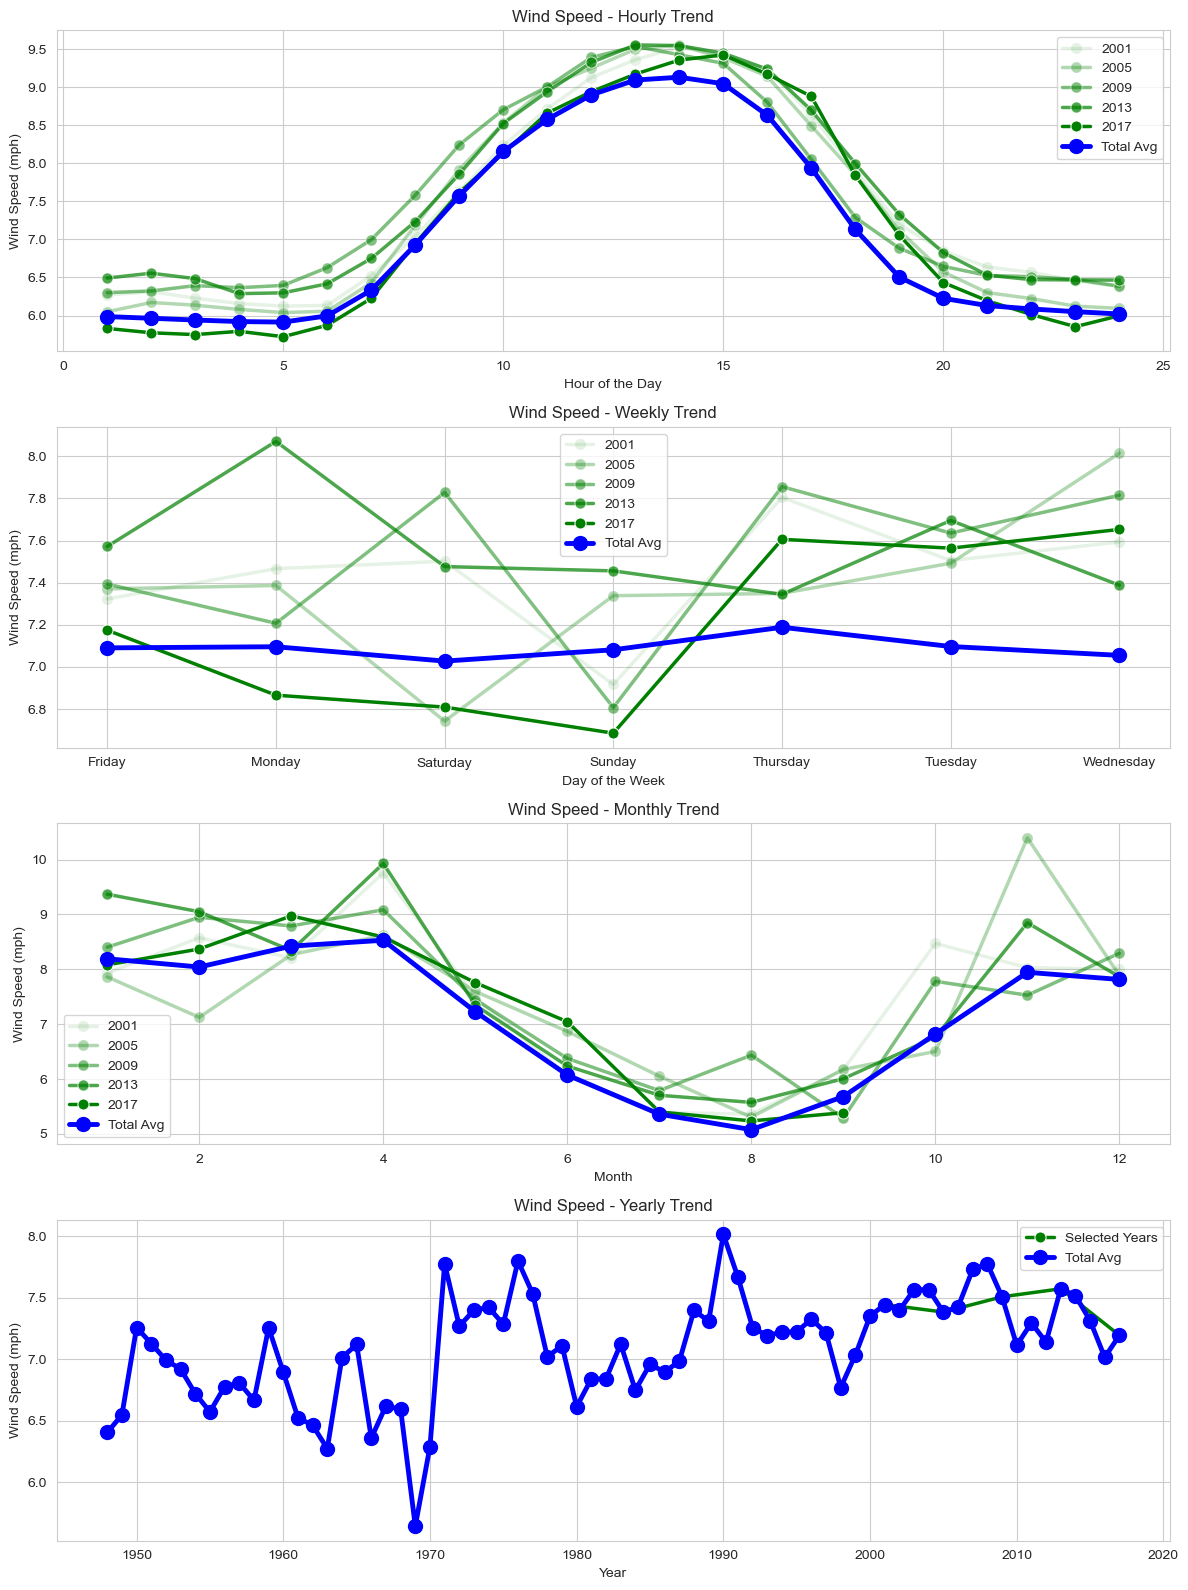

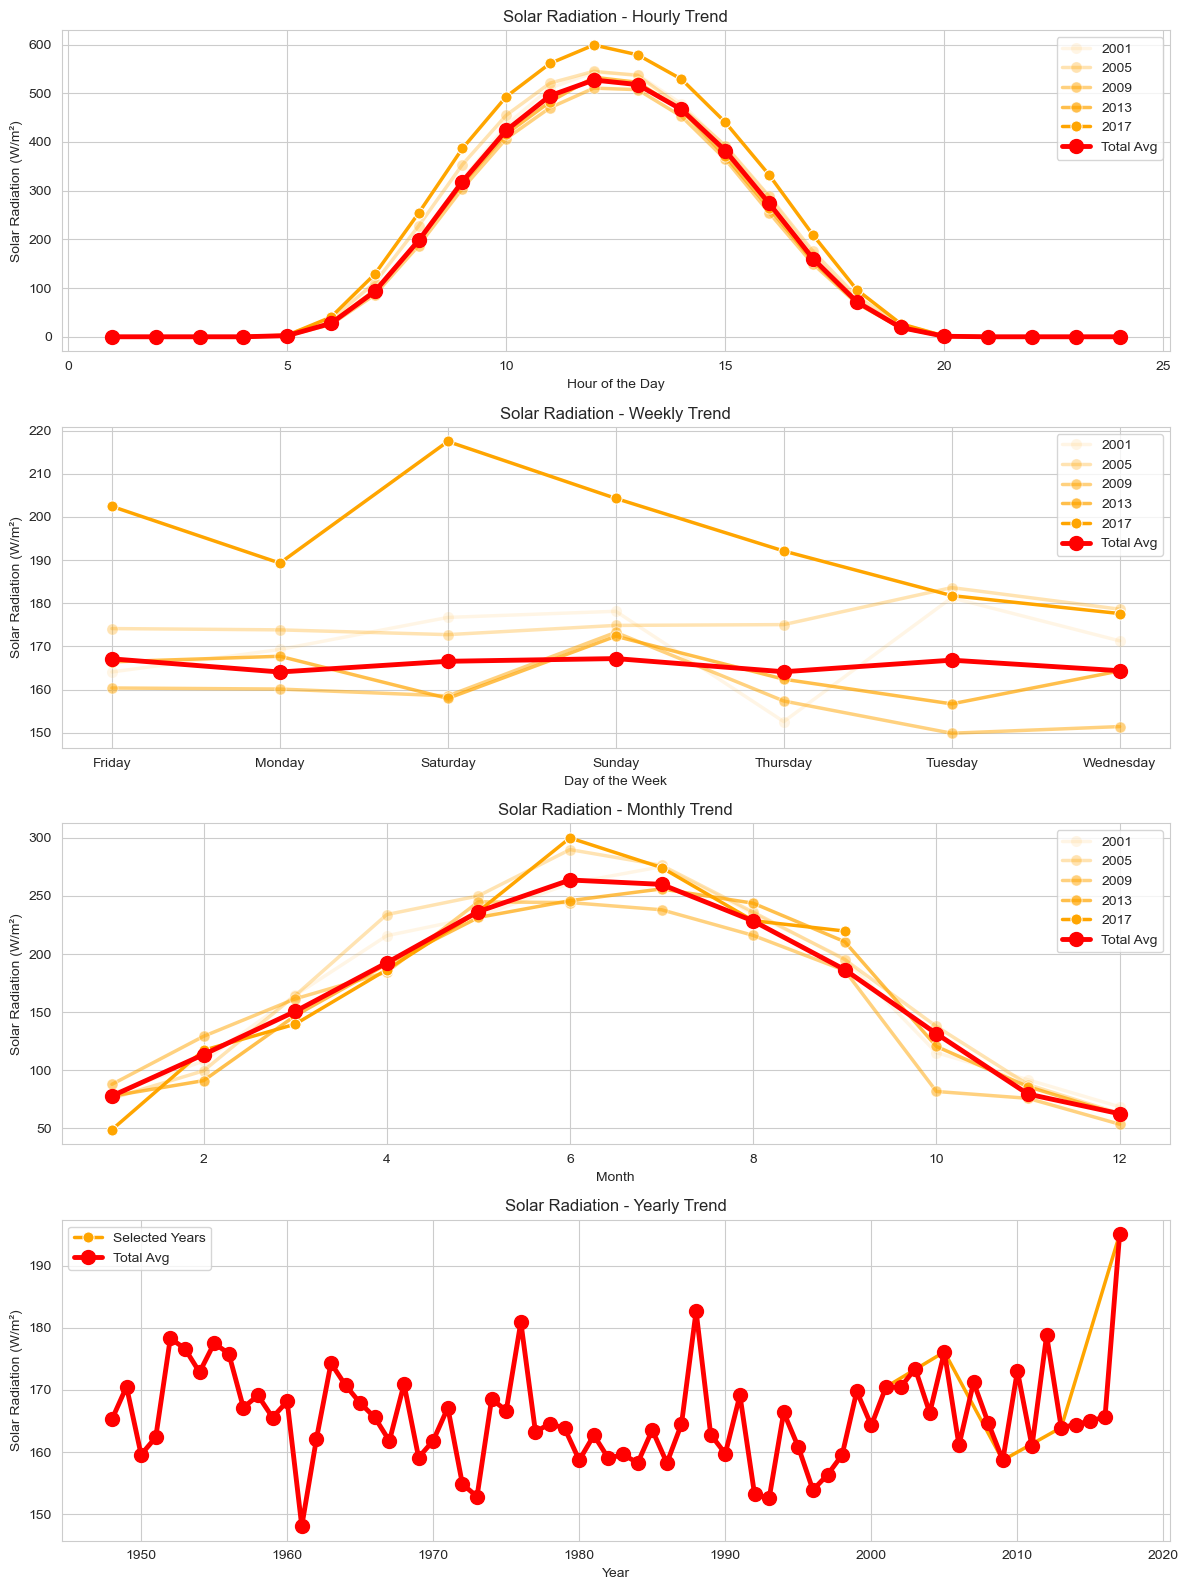

In [79]:
# Define colors for total averages
avg_colors = {'Wind Speed': 'blue', 'Solar Radiation': 'red'}

# lower opacities for older years
year_opacities = {2001: 0.1, 2005: 0.3, 2009: 0.5, 2013: 0.7, 2017: 1.0}


selected_years = [2001, 2005, 2009, 2013, 2017]
filtered_df = final_df[final_df['Year'].isin(selected_years)]

# Set Seaborn style
sns.set_style("whitegrid")

def plot_trends(df, total_df, metric, ylabel, title_prefix, base_color):
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16), sharex=False)

    # --- 1. Plot: Hourly Trend ---
    hourly_data = df.groupby(['Hour', 'Year'])[metric].mean().reset_index()
    total_hourly = total_df.groupby('Hour')[metric].mean()
    for year in selected_years:
        sns.lineplot(
            ax=axes[0],
            data=hourly_data[hourly_data['Year'] == year],
            x='Hour', y=metric,
            color=base_color,
            alpha=year_opacities[year],
            marker='o', linewidth=2.5, markersize=8,
            label=str(year)
        )
    axes[0].plot(total_hourly, color=avg_colors[title_prefix], marker='o', linewidth=3.5, markersize=10, label='Total Avg')
    axes[0].set_title(f"{title_prefix} - Hourly Trend")
    axes[0].set_xlabel("Hour of the Day")
    axes[0].set_ylabel(ylabel)

    # --- 2. Plot: Weekly Trend ---
    daily_data = df.groupby(['Day_of_Week', 'Year'])[metric].mean().reset_index()
    total_daily = total_df.groupby('Day_of_Week')[metric].mean()
    for year in selected_years:
        sns.lineplot(
            ax=axes[1],
            data=daily_data[daily_data['Year'] == year],
            x='Day_of_Week', y=metric,
            color=base_color,
            alpha=year_opacities[year],
            marker='o', linewidth=2.5, markersize=8,
            label=str(year)
        )
    axes[1].plot(total_daily, color=avg_colors[title_prefix], marker='o', linewidth=3.5, markersize=10, label='Total Avg')
    axes[1].set_title(f"{title_prefix} - Weekly Trend")
    axes[1].set_xlabel("Day of the Week")
    axes[1].set_ylabel(ylabel)

    # --- 3. Plot: Monthly Trend ---
    monthly_data = df.groupby(['Month', 'Year'])[metric].mean().reset_index()
    total_monthly = total_df.groupby('Month')[metric].mean()
    for year in selected_years:
        sns.lineplot(
            ax=axes[2],
            data=monthly_data[monthly_data['Year'] == year],
            x='Month', y=metric,
            color=base_color,
            alpha=year_opacities[year],
            marker='o', linewidth=2.5, markersize=8,
            label=str(year)
        )
    axes[2].plot(total_monthly, color=avg_colors[title_prefix], marker='o', linewidth=3.5, markersize=10, label='Total Avg')
    axes[2].set_title(f"{title_prefix} - Monthly Trend")
    axes[2].set_xlabel("Month")
    axes[2].set_ylabel(ylabel)

    # --- 4. Plot: Yearly Trend ---
    yearly_data = df.groupby('Year')[metric].mean().reset_index()
    total_yearly = total_df.groupby('Year')[metric].mean()
    sns.lineplot(
        ax=axes[3],
        data=yearly_data,
        x='Year', y=metric,
        marker='o', color=base_color,
        linewidth=2.5, markersize=8,
        label='Selected Years'
    )
    axes[3].plot(total_yearly, color=avg_colors[title_prefix], marker='o', linewidth=3.5, markersize=10, label='Total Avg')
    axes[3].set_title(f"{title_prefix} - Yearly Trend")
    axes[3].set_xlabel("Year")
    axes[3].set_ylabel(ylabel)
    
    for ax in axes:
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot Wind Speed Trends with Total Average
plot_trends(filtered_df, final_df, 'Wind_Speed', 'Wind Speed (mph)', "Wind Speed", 'green')

# Plot Solar Radiation Trends with Total Average
plot_trends(filtered_df, final_df, 'Solar_Radiation_Wm2', 'Solar Radiation (W/m²)', "Solar Radiation", 'orange')


**The average solar radiation and wind speed over across seasons.**

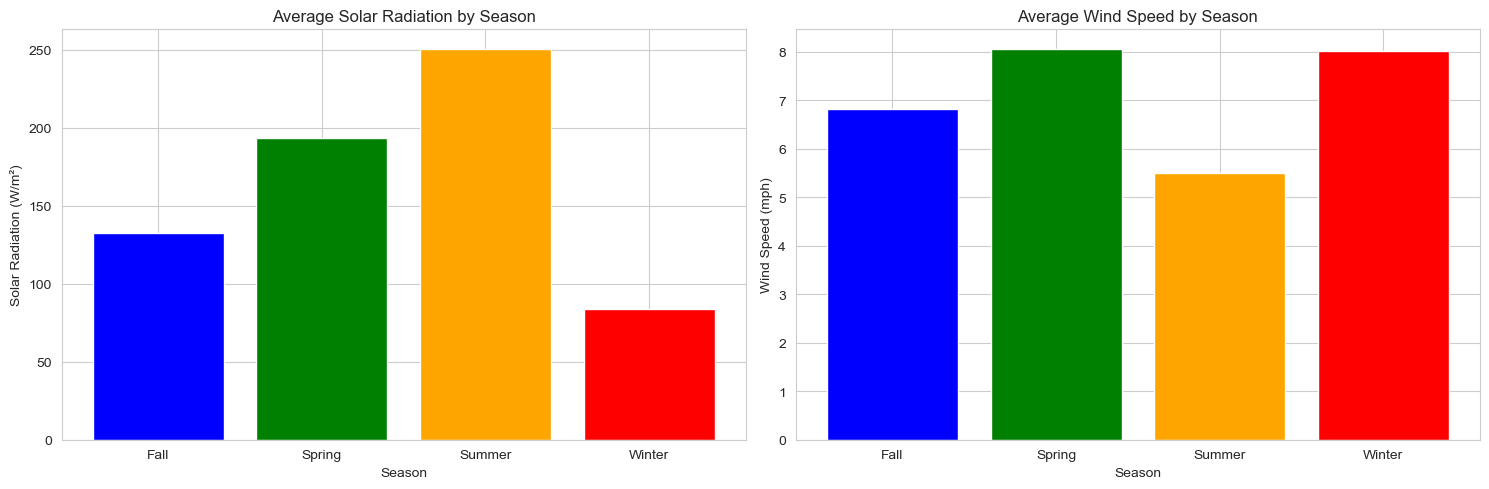

In [80]:
avg_solar_radiation_season = merged_df.groupby('Season')['Solar_Radiation_Wm2'].mean()
avg_wind_speed_season = merged_df.groupby('Season')['Wind_Speed'].mean()

sns.set_style("whitegrid")

# create a side-by-side plot
plt.figure(figsize=(15, 5))
# plot: Wind Speed
plt.subplot(1, 2, 1)
plt.bar(avg_solar_radiation_season.index, avg_solar_radiation_season, color=['blue', 'green', 'orange', 'red'])
plt.title('Average Solar Radiation by Season')
plt.xlabel('Season')
plt.ylabel('Solar Radiation (W/m²)')
plt.grid(True)
# plot: Solar Radiation
plt.subplot(1, 2, 2)
plt.bar(avg_wind_speed_season.index, avg_wind_speed_season, color=['blue', 'green', 'orange', 'red'])
plt.title('Average Wind Speed by Season')
plt.xlabel('Season')
plt.ylabel('Wind Speed (mph)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Predictive Models
`Y = f(x)`
- Y: target variable, which is renewable energy generation (kWh)
- x: focused features include `[solar_radiation, wind_speed, year, month, week, hour]`.  

We are selecting these features because from our analysis on the data we gathered. 

These are the inputs we want to analyze and predict with the different models, which in this case are Linear Regression, Polynomial Regression, and a Random Forest Regressor.


## Linear Regression Model

In [81]:
# see final_df columns
final_df.columns

Index(['Year', 'Month', 'Day', 'Wind_Speed', 'Solar_Radiation_Wm2',
       'Wind_Above_Threshold', 'Solar_Above_Threshold', 'Hour', 'Day_of_Week',
       'Is_Weekend', 'Wind_Power', 'Wind_Energy_Generation', 'Solar_Power',
       'Solar_Energy_Generation', 'Total_Energy_Generation',
       'Time_of_Day_Nighttime', 'Season_Spring', 'Season_Summer',
       'Season_Winter'],
      dtype='object')

In [82]:
final_df.shape

(611424, 19)

In [83]:
# final_df['Total_Energy_Generation'].is_unique()

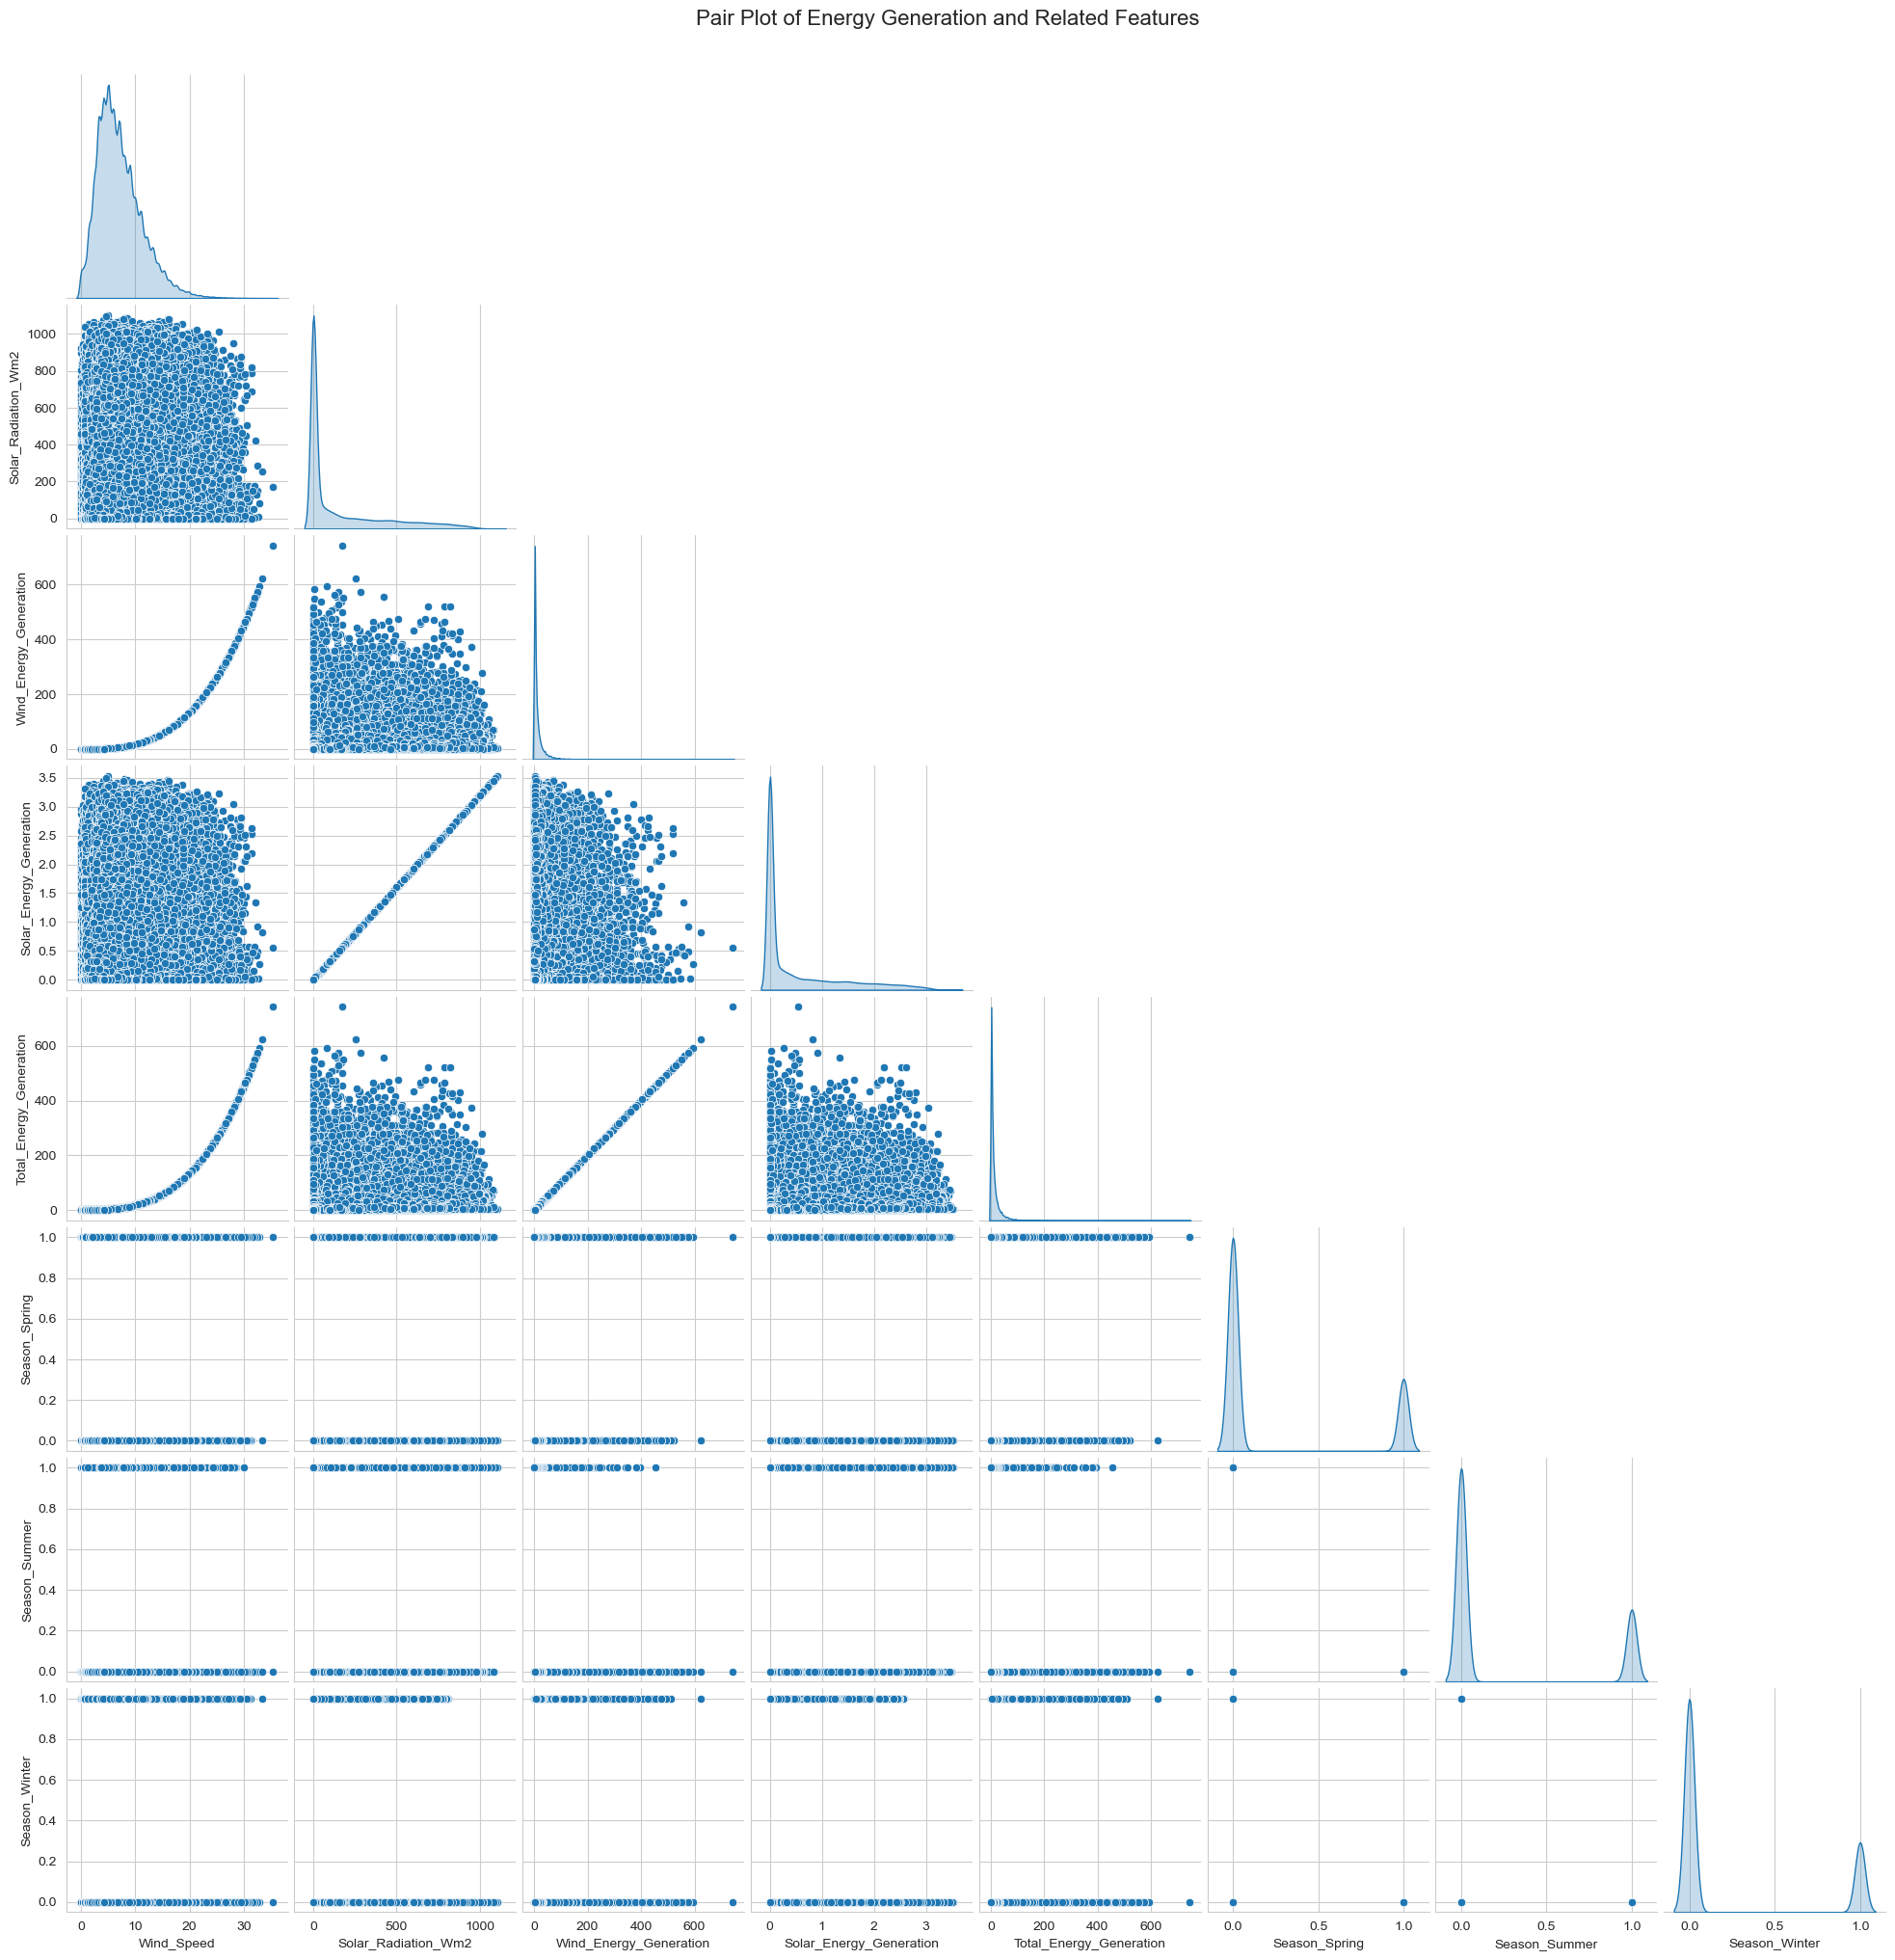

In [84]:
# Select relevant features for pair plotting
features = [
    'Wind_Speed', 
    'Solar_Radiation_Wm2', 
    'Wind_Energy_Generation', 
    'Solar_Energy_Generation', 
    'Total_Energy_Generation',
    'Season_Spring',
    'Season_Summer',
    'Season_Winter'
]

# Create a pair plot
sns.pairplot(final_df[features], diag_kind='kde', corner=True)

# Show the plot
plt.suptitle('Pair Plot of Energy Generation and Related Features', y=1.02, fontsize=16)
plt.show()


In [85]:
# define features and target
features = [
    'Wind_Speed', 
    'Solar_Radiation_Wm2',
    'Time_of_Day_Nighttime',
    'Season_Spring',
    'Season_Summer',
    'Season_Winter'
]
X = final_df[features]
y = final_df['Total_Energy_Generation']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    # 10-fold cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
    
    # fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # print metrics
    print(f"--- {model_name} ---")
    print(f"Cross-Validation R² Score (10-Fold): {scores.mean():.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R²: {r2:.2f}")
    print("\n")
    
    return {'Cross-Validation R²': scores.mean(), 'MSE': mse, 'R2': r2}

In [87]:
# Linear Regression Model

linear_model = LinearRegression()
linear_results = evaluate_model(linear_model, "Linear Regression", X_train, y_train, X_test, y_test)

--- Linear Regression ---
Cross-Validation R² Score (10-Fold): 0.69
MSE: 218.97
R²: 0.68




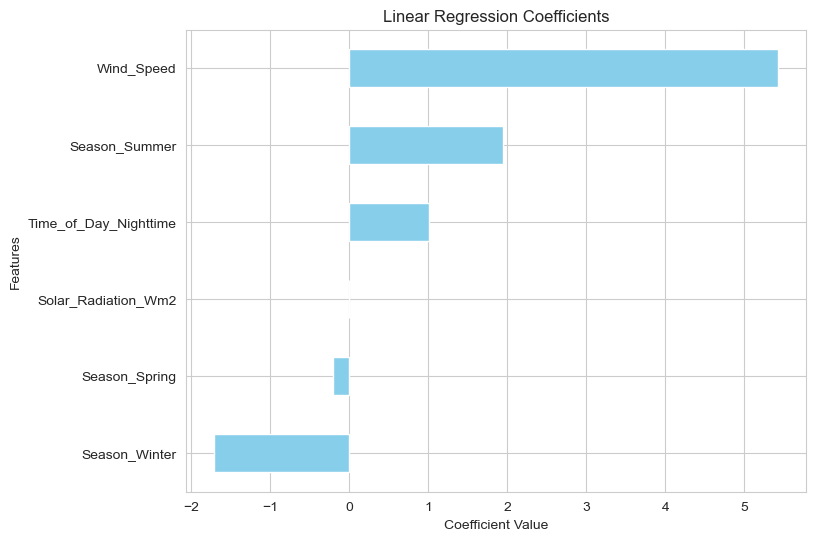

Coefficients of the Linear Regression Model:
Wind_Speed: 5.43 (increases Total Energy Generation)
Solar_Radiation_Wm2: -0.00 (decreases Total Energy Generation)
Time_of_Day_Nighttime: 1.01 (increases Total Energy Generation)
Season_Spring: -0.21 (decreases Total Energy Generation)
Season_Summer: 1.95 (increases Total Energy Generation)
Season_Winter: -1.70 (decreases Total Energy Generation)


In [88]:
# Display the coefficients of the linear model
coefficients = pd.Series(linear_model.coef_, index=features)

# Plotting the coefficients to show their influence on the model
plt.figure(figsize=(8, 6))
coefficients.sort_values().plot(kind='barh', color='skyblue')
plt.title('Linear Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.grid(True)
plt.show()

# Print the coefficient values with their corresponding feature names
print("Coefficients of the Linear Regression Model:")
for feature, coef in coefficients.items():
    relation = "increases" if coef > 0 else "decreases"
    print(f"{feature}: {coef:.2f} ({relation} Total Energy Generation)")


In [89]:

#  Random Forest Regression Model 
random_forest_model = RandomForestRegressor(
    n_estimators=50,         # Reduced number of trees
    max_depth=5,             # Reduced depth to limit complexity
    min_samples_split=20,    # More samples needed to split a node
    min_samples_leaf=10,     # More samples needed at a leaf node
    max_features='sqrt',     # Keep feature diversity per split
    random_state=42
)
rf_results = evaluate_model(random_forest_model, "Random Forest Regression", X_train, y_train, X_test, y_test)

# extra for random forest
# feature importances from the random forest model
feature_importances = pd.Series(random_forest_model.feature_importances_, index=features)
feature_importances


--- Random Forest Regression ---
Cross-Validation R² Score (10-Fold): 0.88
MSE: 82.39
R²: 0.88




Wind_Speed               0.938546
Solar_Radiation_Wm2      0.017059
Time_of_Day_Nighttime    0.016192
Season_Spring            0.005941
Season_Summer            0.018605
Season_Winter            0.003657
dtype: float64

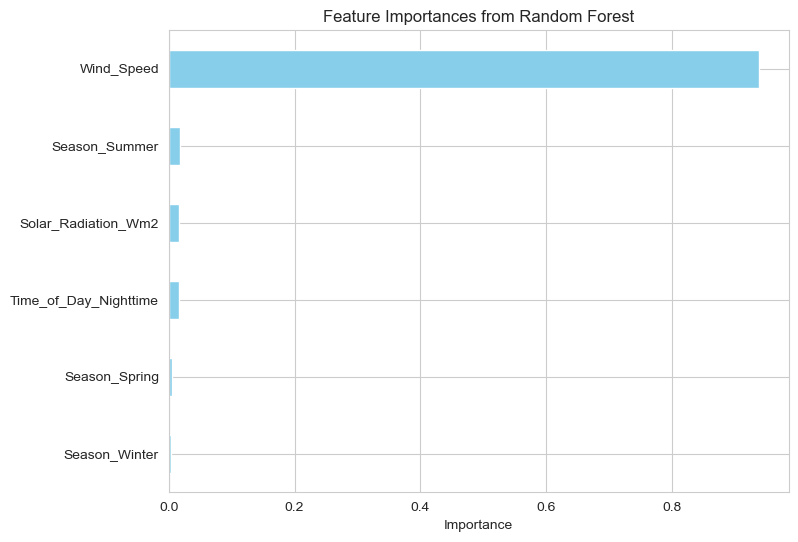

In [90]:
# plot feature importances
plt.figure(figsize=(8, 6))
feature_importances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.show()

In [91]:
# # Train & Evaluate Linear Regression
# linear_model = LinearRegression()
# linear_results = evaluate_model(linear_model, X_train, y_train, X_test, y_test)
# # print results
# linear_results = pd.Series(linear_results, name='Linear Regression')
# linear_results

In [92]:
# import matplotlib.pyplot as plt
# plt.hist(y_test)

In [93]:
# # Train & Evaluate Random Forest
# rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
# rf_model.fit(X_train, y_train)  # Ensure model is trained before extracting feature importances
# rf_results = evaluate_model(rf_model, X_train, y_train, X_test, y_test)

# # Print Feature Importances
# print("\nRandom Forest Feature Importances:")
# feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
# feature_importances


**Linear Regression Model Findings**

Considering on the model performance, we have the Mean Squared Error (MSE): 0.381 which measures the average squared difference between the predicted actual energy generated. We'll try different models to see which results in a lower MSE which indicates a better fit. At the same time, the R-squared Score: 0.316, which means 31.6% of the variation in renewable energy generation is explained by the model. While this is not a high percentage, we can infer that other unaccounted factors influence energy generation.

The Time_of_Day_Nighttime coefficient is -0.83, meaning it has a strong negative impact on energy generation. Since solar panels do not generate energy at night, we expected this. Thus, daytime is crucial for energy generation. Moreover, we can infer that Spring is the best season due to a combination of long days and strong winds, followed by winter, summer, and fall This also tracks with our data, since spring has a combination of high winds and long days, making it ideal for both wind and solar generation. Winter has the shortest days but also high winds, summer has long days but very low winds compared to the other three seasons, and fall has shorter days and medium wind speeds. The model explains 31.6% of the variability in energy generation, suggesting that other factors (e.g., cloud cover, temperature, humidity) might need to be incorporated for better accuracy.

In [94]:
# import matplotlib.pyplot as plt

# # Coefficients for the selected features: Seasons and Time of Day (Nighttime)
# coefficients = {
#     'Solar_Radiation_Wm2': 0.0014255548542642588,
#     'Wind_Speed': 0.0946140711125815,
#     'Time_of_Day_Nighttime': -0.20415576009292669,
#     'Season_Spring': -0.009903176649089136,
#     'Season_Summer': -0.02157077743652856,
#     'Season_Winter': 0.004476060400113012
# }

# # Features and their corresponding coefficient values
# features = list(coefficients.keys())
# values = list(coefficients.values())

# # Create a horizontal bar chart for the selected features
# plt.figure(figsize=(8, 5))
# plt.barh(features, values, color='skyblue')
# plt.xlabel('Coefficient Value')
# plt.title('Impact of Time of Day and Seasons on Renewable Energy Generation')
# plt.grid(True)
# plt.show()


### Polynomial Regressor

In [95]:
# # Scale the features (important for polynomial regression)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # apply PolynomialFeatures (e.g., degree 2 for quadratic features)
# poly = PolynomialFeatures(degree=2)
# X_train_poly = poly.fit_transform(X_train_scaled)
# X_test_poly = poly.transform(X_test_scaled)

# # initialize and train the Linear Regression model on polynomial features
# model = LinearRegression()
# model.fit(X_train_poly, y_train)

# # make predictions
# y_pred = model.predict(X_test_poly)

# # calculate MSE and R²
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# # print the coefficients
# print("Polynomial Regression Results:")
# poly_results = {
#     "Mean Squared Error (MSE)": mse,
#     "R-squared Score": r2,
#     "Model Coefficients": dict(zip(X.columns, model.coef_))}
# poly_results

**Polynomial Regression Model Findings**

The Polynomial Regression Model shows a slight improvement over the Linear Regression Model, as the Mean Squared Error is lower(0.372 vs. 0.381) and the R-squared score is higher (0.333 vs. 0.316). The polynomial model captures some nonlinear relationships in the data better than the linear model.

Unlike the linear model, the nighttime coefficient from the polynomial model's result is 0.0, suggesting it found no additional nonlinearity in the impact of nighttime on energy generation. In the linear regression model, the coefficient for Time_of_Day_Nighttime is -0.83, meaning nighttime has a strong negative impact on renewable energy generation compared to daytime. On the other hand, the polynomial regression model for Time_of_Day_Nighttime is 0.0, meaning the model did not find any additional nonlinearity in the effect of nighttime. The relationship between nighttime and energy generation is already well captured by a linear term.

The polynomial model produces much larger coefficients for seasonal variables. Spring and Winter have opposing signs (Spring: negative, Winter: positive), which may indicate complex interactions or overfitting. Summer shows a large negative coefficient, suggesting it has a much lower energy generation potential in this model. Overall, the polynomial model provides a better fit but might be overfitting because it results in extreme coefficient values.

In [96]:

# # Polynomial Regression coefficients for the selected features: Seasons and Time of Day (Nighttime)
# coefficients = {
#     'Solar_Radiation_Wm2': 3273318.669846907,
#     'Wind_Speed': 0.7609244189507554,
#     'Time_of_Day_Nighttime': 0.0036889639754301567,
#     'Season_Spring': -179798741.6199952,
#     'Season_Summer': -72255451978.53279,
#     'Season_Winter': 162117461799.07062
# }

# # Features and their corresponding coefficient values
# features = list(coefficients.keys())
# values = list(coefficients.values())

# # Create a horizontal bar chart for the selected features
# plt.figure(figsize=(8, 5))
# plt.barh(features, values, color='lightgreen')
# plt.xlabel('Coefficient Value')
# plt.title('Impact of Time of Day and Seasons on Renewable Energy Generation (Polynomial Regression)')
# plt.grid(True)
# plt.show()

### Random Forest Regressor Model

In [97]:
# # initialize and train the Random Forest
# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# feature_importances = model.feature_importances_
# feature_names = X.columns
# feature_importance_dict = {feature_names[i]: feature_importances[i] for i in range(len(feature_names))}

# # Output the results
# print("RandomForestRegressor Results:")
# print(f"Mean Squared Error (MSE): {mse}")
# print(f"R-squared Score (R²): {r2}")
# print("Feature Importances:")
# feature_importance_dict

In [98]:

# # # Plot the feature importances
# # plt.figure(figsize=(8, 5))
# # plt.barh(feature_names, feature_importances, color='lightcoral')
# # plt.xlabel('Feature Importance')
# # plt.title('Feature Importance: Random Forest Regressor')
# # plt.grid(True)
# # plt.show()

# # convert feature importance dictionary to DataFrame
# feature_importance_df = pd.DataFrame(list(feature_importance_dict.items()), columns=['Feature', 'Importance'])

# # filter for specific features
# selected_features = ['Solar_Radiation_Wm2','Wind_Speed', 'Time_of_Day_Nighttime', 'Season_Winter', 'Season_Spring', 'Season_Summer', 'Season_Fall']
# filtered_df = feature_importance_df[feature_importance_df['Feature'].isin(selected_features)]

# # plot
# plt.figure(figsize=(8, 5))
# plt.bar(filtered_df['Feature'], filtered_df['Importance'], color= 'coral')
# plt.xlabel('Feature')
# plt.ylabel('Importance')
# plt.title('Feature Importances for Time of Day & Seasons')
# plt.xticks(rotation=45)
# plt.show()

In [99]:
# Performance metrics comparison
models = ['Linear Regression', 'Random Forest', 'Polynomial Ridge']
mse_values = [linear_results['MSE'], rf_results['MSE']]
r2_values = [linear_results['R2'], rf_results['R2']]
cv_scores = [linear_results['Cross-Validation Score'], rf_results['Cross-Validation Score']]

# Create figure
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.bar(models, mse_values, color=['royalblue', 'firebrick', 'seagreen'])
plt.ylabel("Mean Squared Error")
plt.title("Model MSE Comparison")

# Plot R² scores
plt.subplot(1, 2, 2)
plt.bar(models, r2_values, color=['royalblue', 'firebrick', 'seagreen'])
plt.ylabel("R² Score")
plt.title("Model R² Comparison")

plt.tight_layout()
plt.show()

# Print performance metrics
print("\nModel Performance:")
for i, model in enumerate(models):
    print(f"{model} - CV Score: {cv_scores[i]:.4f}, MSE: {mse_values[i]:.4f}, R²: {r2_values[i]:.4f}")


KeyError: 'Cross-Validation Score'

**Random Forest Model Findings**

In terms of model prediction performance, with Random Forest Regressor model, we found that the Mean Squared Error (MSE) 0.372 is lower than the Linear Regression Model (0.381), meaning it makes slightly better predictions, similar to the Polynomial Regression model predictions. Additionally, the resulted R-squared Score is 0.333, which is higher than Linear Regression (0.316), meaning the Random Forest explains slightly more variance in energy generation. Similarly to the Polynomial Regression Model (0.333), where both methods capture important nonlinear patterns.

From our coefficient findings, Time_of_Day_Nighttime (91.56%) is by far the most important feature in predicting energy generation. This makes sense because solar energy is completely unavailable at night, creating a major contrast between daytime and nighttime. The high importance suggests that most of the predictive power comes from whether it is day or night, overshadowing seasonal differences. All seasonal variables have very low importance compared to time of day, Season_Spring (3.73%), Season_Summer (3.96%), Season_Winter (0.76%). This suggests that while seasonal changes (such as daylight hours and wind speeds) do affect energy generation, they are not as crucial as the fundamental day vs. night difference. Spring and Summer are slightly more important than Winter, which aligns with the expectation that longer daylight hours boost energy production. Winter has the lowest importance (0.76%), likely because while wind speeds are higher, the short days still limit overall energy generation.

Random Forest performs better than linear regression and is on par with the polynomial regression model in terms of accuracy However, Random Forest is more flexible and robust since it captures complex relationships without requiring explicit polynomial transformations. It also provides feature importances, which help in understanding which factors drive energy generation.

In [ ]:
final_df.columns

Index(['Year', 'Month', 'Day', 'Wind_Speed', 'Solar_Radiation_Wm2',
       'Wind_Above_Threshold', 'Solar_Above_Threshold', 'Hour', 'Day_of_Week',
       'Is_Weekend', 'Total_Energy_Generation', 'Time_of_Day_Nighttime',
       'Season_Spring', 'Season_Summer', 'Season_Winter'],
      dtype='object')

In [ ]:
# # Selected features after one-hot encoding
# selected_features = ['Year', 'Month', 'Day', 'Wind_Speed', 'Solar_Radiation_Wm2', 
#                      'Wind_Above_Threshold', 'Solar_Above_Threshold', 'Hour', 'Is_Weekend',
#                      'Season_Spring', 'Season_Winter', 'Season_Summer']

# # Create a figure 
# fig, ax1 = plt.subplots(figsize=(10, 7))

# # Coefficient/Importance Bar Chart (Including Polynomial Regression)
# bar_width = 0.25  # Narrower bars to match style
# x_indexes = np.arange(len(selected_features))

# # Linear Regression coefficients
# ax1.barh(x_indexes, linear_model.coef_[:len(selected_features)], bar_width, 
#          label='Linear Regression', color='blue', alpha=0.7)

# # Random Forest feature importances
# ax1.barh(x_indexes + bar_width, rf_model.feature_importances_[:len(selected_features)], 
#          bar_width, label='Random Forest', color='orange', alpha=0.7)

# # Ridge (Polynomial Regression) coefficients
# ax1.barh(x_indexes + 2 * bar_width, ridge_model.coef_[:len(selected_features)], 
#          bar_width, label='Polynomial Regression', color='green', alpha=0.7)

# ax1.set_yticks(x_indexes + bar_width)
# ax1.set_yticklabels(selected_features)
# ax1.set_xlabel('Coefficient/Importance Value')
# ax1.set_title('Model Coefficients/Feature Importances')
# ax1.legend()
# ax1.grid(True, axis='x')

# # Show the plot
# fig.tight_layout()
# plt.show()

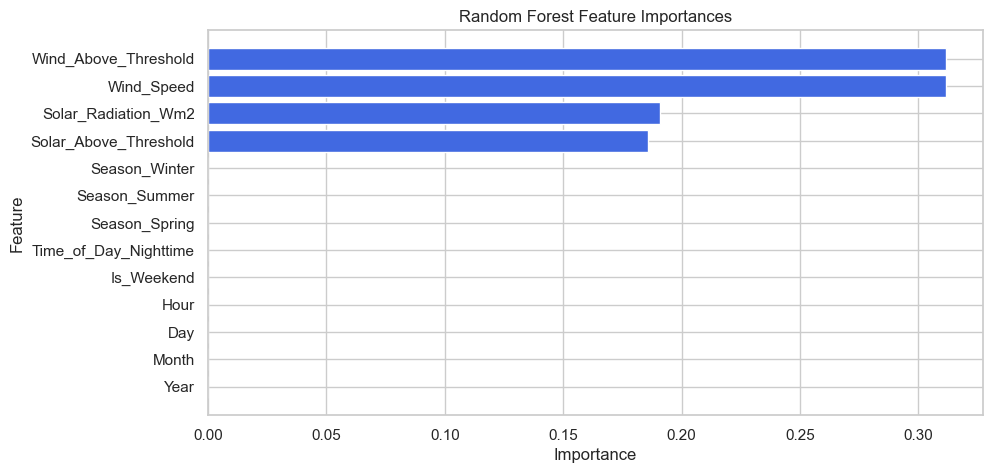

In [ ]:
# Feature names and their importances
features = ["Year", "Month", "Day", "Wind_Speed", "Solar_Radiation_Wm2", "Wind_Above_Threshold", "Solar_Above_Threshold", "Hour", "Is_Weekend", "Time_of_Day_Nighttime", "Season_Spring", "Season_Summer", "Season_Winter"]
importances = [0.0, 0.0, 0.0, 0.3117, 0.1907, 0.3117, 0.1859, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.barh(sorted_features, sorted_importances, color='royalblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

### Model Analysis Conclusion

Given the different model we tried, our calculated MSE and R-squared score, we can identify the model provides better and more accurate predictions.

The lower the MSE, the more accurate it is to the actual values. Moreover, the closer the R-squared score is closer to 1, the better prediction it is. Thus, of the three models we used, we can conclude that the most accurate predictions for renewable energy generation we should use is Random Forest is the best model. This is because it matches Polynomial Regression in accuracy but avoids overfitting and provides better feature importance insights, captures nonlinear relationships without requiring manual polynomial transformations, and clearly highlights that time of day is the most important factor, while seasonal variation has a much smaller impact.

Linear Regression is the easiest to interpret but oversimplifies the relationships. Polynomial Regression is harder to interpret due to large, unstable coefficients. From the Random Forest model, we clearly see that time of day dominates energy generation (91.56% importance). Seasonal variables are much less significant, meaning a model relying too much on seasonality (like polynomial regression) may be overfitting. Thus, in this case, Random Forest is the better model of the three we had tested.
